In [2]:
from datasets import load_dataset
import seaborn as sns
from dotenv import load_dotenv
from juddges.settings import ROOT_PATH

In [3]:
load_dotenv(ROOT_PATH / ".env", override=True)
# import os
# print(os.getenv("HF_TOKEN"))

dataset = load_dataset("JuDDGES/nsa")

# Sample 20% of the dataset randomly
sample_size = int(len(dataset["train"]) * 0.2)
dataset["train"] = dataset["train"].shuffle(seed=17).select(range(sample_size))
dataset

Using the latest cached version of the dataset since JuDDGES/nsa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/albert/.cache/huggingface/datasets/JuDDGES___nsa/default/0.0.0/a2c1510bb1ae9eee9f5a1953b1b7646e0ed72314 (last modified on Thu Dec 19 10:56:59 2024).


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'Docket number', 'Type of decision', 'Finality', 'The day of the judgment', 'Date of submission', 'Court', 'Judges', 'Presiding judge', 'Judge rapporteur', 'Type of case with the detailed description', 'Keywords', 'Related docket numbers', 'Challenged authority', 'Nature of the verdict', 'The cited provisions', 'Published in official collection of judgments Jurisprudence of the Voivodeship Administrative Courts and the Supreme Administrative Court', 'Information on glosa(s)', 'Theses', 'Sentence of the judgment', 'Reasons for judgment', 'Dissenting opinion'],
        num_rows: 422853
    })
})

In [4]:
date_column = 'The day of the judgment'

In [5]:
from datetime import datetime


def date_to_datetime(entry: dict) -> dict:
    entry[date_column] = datetime.strptime(entry[date_column], "%Y-%m-%d")
    return entry

dataset = dataset.map(date_to_datetime, num_proc=15)

ds = dataset["train"]
ds_recent = ds.filter(lambda x: x[date_column] >= datetime(2020, 1, 1))
ds = ds.map(lambda x: {"year": x[date_column].year}, num_proc=15)
ds = ds.map(lambda x: {"month": x[date_column].month}, num_proc=15)

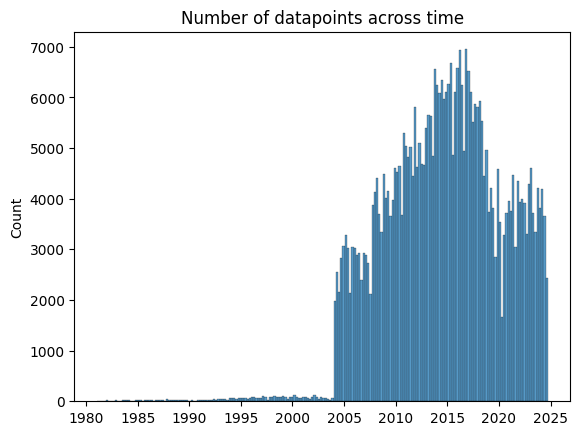

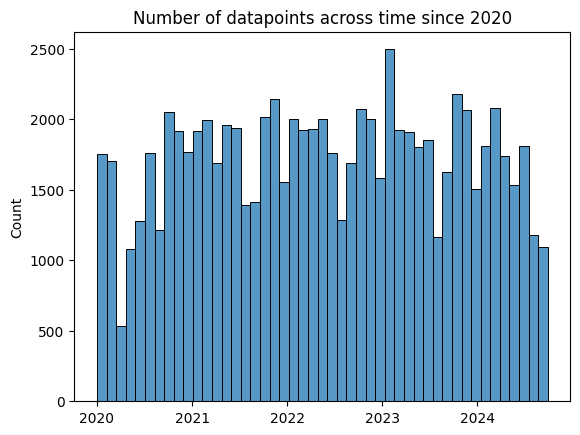

In [6]:
from matplotlib import pyplot as plt

sns.histplot(ds[date_column])
plt.title("Number of datapoints across time")
plt.show()

sns.histplot(ds_recent[date_column])
plt.title("Number of datapoints across time since 2020")
plt.show()


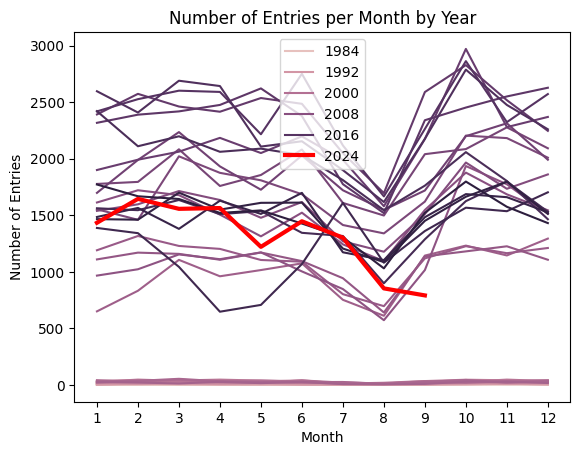

In [7]:
# Create a DataFrame and count entries per month-year combination
df = ds.to_pandas()
monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')

# Create the line plot
g = sns.lineplot(
    data=monthly_counts[monthly_counts['year'] != 2024],  # Plot all years except 2024
    x="month",
    y="count",
    hue="year"
)

# Add 2024 line with custom style
sns.lineplot(
    data=monthly_counts[monthly_counts['year'] == 2024],
    x="month",
    y="count",
    color='red',
    linewidth=3,
    label='2024'
)

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Number of Entries")
plt.title("Number of Entries per Month by Year")
plt.xticks(range(1, 13))

plt.show()


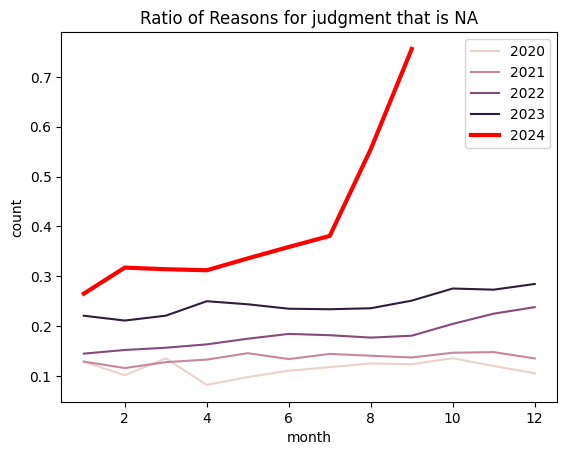

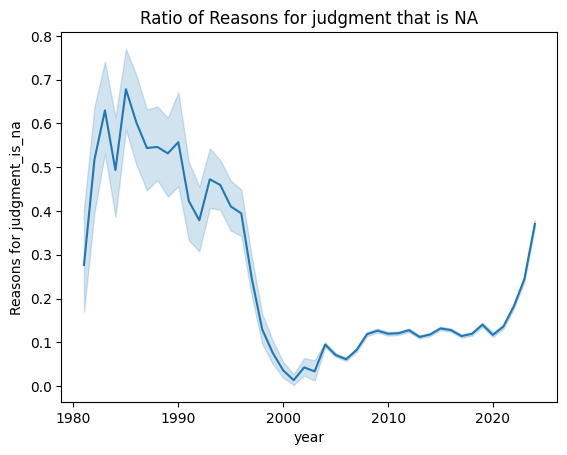

In [8]:
import pandas as pd

columns_to_examine = ["Reasons for judgment"]

for column in columns_to_examine:
    df[f"{column}_is_na"] = df[column].isna()
    monthly_counts = df[df["year"] > 2019].groupby(['year', 'month'])[f"{column}_is_na"].mean().reset_index(name='count')
    

    # Create the line plot
    ax = sns.lineplot(
        data=monthly_counts[monthly_counts['year'] != 2024],  # Plot all years except 2024
        x="month",
        y="count",
        hue="year"
    )

    # Add 2024 line with custom style
    sns.lineplot(
        data=monthly_counts[monthly_counts['year'] == 2024],
        x="month",
        y="count",
        color='red',
        linewidth=3,
        label='2024'
    )

    ax.set_title(f"Ratio of {column} that is NA")
    plt.show()
    
    df["YEAR_MONTH"] = df["year"].astype(str) + "_" + df["month"].astype(str)
    df["YEAR_MONTH"] = pd.to_datetime(df["YEAR_MONTH"], format="%Y_%m")

    sns.lineplot(
        data=df,
        x="year",
        y=f"{column}_is_na",
    )
    plt.title(f"Ratio of {column} that is NA")
    plt.show()




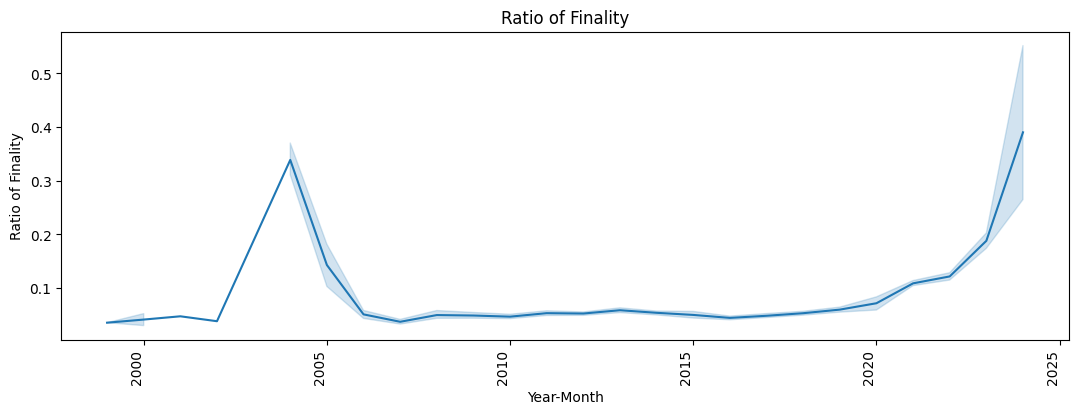

In [9]:

monthly_counts = df.groupby(['year', 'month', "Finality"])["id"].count().reset_index(name='count')

monthly_counts = monthly_counts.pivot(index=["year", "month"], columns="Finality", values="count")

monthly_counts["Finality ratio"] = monthly_counts['orzeczenie nieprawomocne'] / (monthly_counts['orzeczenie nieprawomocne'] + monthly_counts['orzeczenie prawomocne'])

monthly_counts = monthly_counts.reset_index()

monthly_counts["YEAR_MONTH"] = monthly_counts["year"].astype(str) + "_" + monthly_counts["month"].astype(str)


fig = plt.figure(figsize=(13, 4))
# Create the line plot
ax = sns.lineplot(
    data=monthly_counts,
    x="year",
    y="Finality ratio",
)

ax.set_title(f"Ratio of Finality")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Ratio of Finality")
plt.xticks(rotation=90, ha='right')

plt.show()

1. There is increase of ratio of finality. And there is a spike in 2024. 
2. Ratio of lacking reasons is increasing from 2000. With a spike in last month before data was scraped.

What to do?
1. Reacquire datapoints with missing reasons.
2. Reacquire datapoints that are not final.
3. Do not reacquire datapoints that older than Threshold.


In [10]:

print("% of datapoints with missing reasons or not final: ")
print(f"{(df['Reasons for judgment_is_na'] | (df['Finality'] == 'orzeczenie nieprawomocne')).mean():.2%}")


% of datapoints with missing reasons or not final: 
19.17%


In [11]:

recent_df = df[df["year"] >= 2024]
print("% of datapoints with missing reasons or not final in 2024: ")
print(f"{(recent_df['Reasons for judgment_is_na'] | (recent_df['Finality'] == 'orzeczenie nieprawomocne')).mean():.2%}")



% of datapoints with missing reasons or not final in 2024: 
54.87%


#### Experiment with newly acquired dataset for 01.01.2024 - 05.09.2024

In [34]:
from datasets import load_from_disk

new_df = pd.read_parquet(ROOT_PATH / "data/datasets/nsa/dataset/")
dataset = load_dataset("JuDDGES/nsa")

Using the latest cached version of the dataset since JuDDGES/nsa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/albert/.cache/huggingface/datasets/JuDDGES___nsa/default/0.0.0/a2c1510bb1ae9eee9f5a1953b1b7646e0ed72314 (last modified on Thu Dec 19 10:56:59 2024).


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

In [36]:
olds_ids = set(dataset["train"]["id"])
new_df["was_in_old_dataset"] = new_df["id"].isin(olds_ids)
new_df["date"] = pd.to_datetime(new_df["judgment_date"])

In [37]:
print(f"% of datapoints that were not in the old dataset: {(~new_df['was_in_old_dataset']).mean():.2%}")

% of datapoints that were not in the old dataset: 10.95%


<Axes: xlabel='date', ylabel='was_in_old_dataset'>

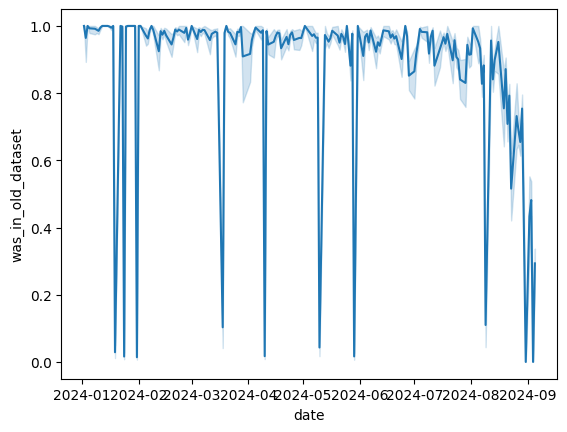

In [38]:
sns.lineplot(data=new_df, x="date", y="was_in_old_dataset")


In [39]:
new_df["month"] = new_df["date"].dt.month
new_df["year"] = new_df["date"].dt.year


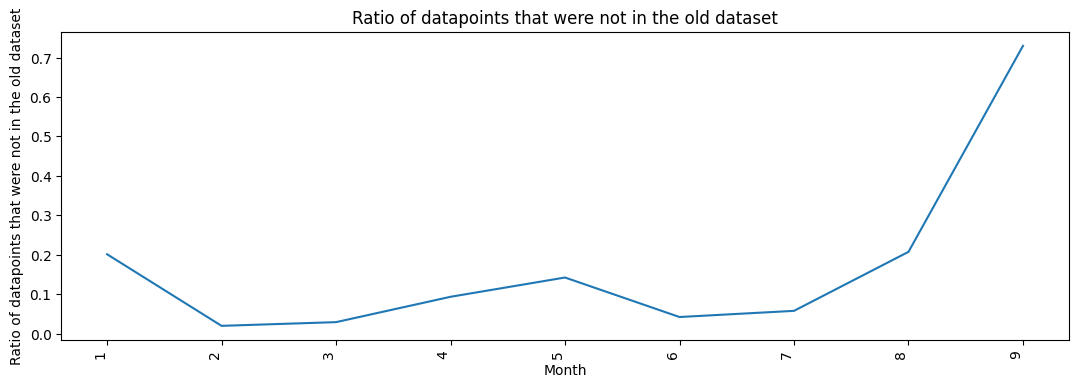

In [53]:
monthly_counts = new_df.groupby(['year', 'month', "was_in_old_dataset"])["id"].count().reset_index(name='count')

monthly_counts = monthly_counts.pivot(index=["month"], columns="was_in_old_dataset", values="count")

monthly_counts["ratio"] = monthly_counts[False] / (monthly_counts[False] + monthly_counts[True])

monthly_counts = monthly_counts.reset_index()


fig = plt.figure(figsize=(13, 4))
# Create the line plot
ax = sns.lineplot(
    data=monthly_counts,
    x="month",
    y="ratio",
)

ax.set_title(f"Ratio of datapoints that were not in the old dataset")
ax.set_xlabel("Month")
ax.set_ylabel("Ratio of datapoints that were not in the old dataset")
plt.xticks(rotation=90, ha='right')

plt.show()